# Model Selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from time import time

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neural_network import MLPRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import nir_preprocessing as nir_prep

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')


from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

## 1. Data Loading and Setup

In [2]:
processed_dataset = joblib.load('nir_tomato_processed_dataset.joblib')

X = processed_dataset['X']
y = processed_dataset['y']
data_splits = processed_dataset['data_splits']

# Split the data using indices from preprocessing
X_train = X.loc[data_splits['train_indices']]
X_val = X.loc[data_splits['val_indices']]
X_test = X.loc[data_splits['test_indices']]

y_train = y.loc[data_splits['train_indices']]
y_val = y.loc[data_splits['val_indices']]
y_test = y.loc[data_splits['test_indices']]

print(f"Training set: {X_train.shape} samples")
print(f"Validation set: {X_val.shape} samples")
print(f"Test set: {X_test.shape} samples")

Training set: (255, 126) samples
Validation set: (86, 126) samples
Test set: (86, 126) samples


In [3]:
# Create preprocessing pipelines
nir_pipelines = nir_prep.create_preprocessing_pipelines()
print(f"Available NIR preprocessing methods: {list(nir_pipelines.keys())}")

Available NIR preprocessing methods: ['raw', 'snv', 'sg1', 'sg2', 'msc', 'snv_pca', 'sg1_pca']


In [4]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)

    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)

    return {
        'train_rmse': train_rmse,
        'train_r2': train_r2,
        'train_mae': train_mae,
        'val_rmse': val_rmse,
        'val_r2': val_r2,
        'val_mae': val_mae,
        'y_train_pred': y_train_pred,
        'y_val_pred': y_val_pred
    }

In [5]:
# Training basic regression models
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "SVR": SVR(),
    "ElasticNet": ElasticNet(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "LightGBM": LGBMRegressor(random_state=42, verbose=-1)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time_base = time()
    
    # Turn off warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        model.fit(X_train, y_train)
    
    end_time_base = time()

    results[name] = evaluate_model(model, X_train, y_train, X_val, y_val)
    results[name]['training_time'] = end_time_base - start_time_base

    print(f"{name} - Training time: {results[name]['training_time']:.2f}s")
    print(f"{name} - Validation RMSE: {results[name]['val_rmse']:.4f}")
    print(f"{name} - Validation R²: {results[name]['val_r2']:.4f}")


Training Random Forest...
Random Forest - Training time: 0.49s
Random Forest - Validation RMSE: 0.2997
Random Forest - Validation R²: 0.7477

Training SVR...
SVR - Training time: 0.00s
SVR - Validation RMSE: 0.5678
SVR - Validation R²: 0.0943

Training ElasticNet...
ElasticNet - Training time: 0.00s
ElasticNet - Validation RMSE: 0.6008
ElasticNet - Validation R²: -0.0138

Training XGBoost...
XGBoost - Training time: 0.46s
XGBoost - Validation RMSE: 0.3168
XGBoost - Validation R²: 0.7182

Training LightGBM...
LightGBM - Training time: 0.08s
LightGBM - Validation RMSE: 0.3113
LightGBM - Validation R²: 0.7278


In [6]:
# MLP optimization with NIR preprocessing
mlp_pipeline = Pipeline([
    ('preprocessor', None),
    ('model', MLPRegressor(max_iter=10000, random_state=42))
])

# Define the hyperparameter grid
mlp_param_grid = {
    'preprocessor': list(nir_pipelines.values()),
    'model__hidden_layer_sizes': [
        (50,), (100,),
        (50, 25), (100, 50)
    ],
    'model__activation': ['relu', 'tanh'],
    'model__alpha': [0.0001, 0.001],
    'model__solver': ['adam', 'lbfgs']
}

# Randomized search with cross-validation
mlp_search = RandomizedSearchCV(
    mlp_pipeline,
    mlp_param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    start_time = time()

    mlp_search.fit(X_train, y_train)

    end_time = time()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of 

In [8]:
# Get the best MLP model
best_mlp = mlp_search.best_estimator_
print(f"Best MLP RMSE: {-mlp_search.best_score_:.4f}")

best_params = mlp_search.best_params_
print("\nBest MLP parameters:")
for param, value in best_params.items():
    if param.startswith('model__'):
        print(f"  {param.replace('model__', '')}: {value}")

# Get the best preprocessing method
best_preprocessing = None
for name, pipeline in nir_pipelines.items():
    if pipeline == best_params['preprocessor']:
        best_preprocessing = name
        break

print(f"\nBest preprocessing method: {best_preprocessing}")

Best MLP RMSE: 0.3223

Best MLP parameters:
  solver: lbfgs
  hidden_layer_sizes: (100, 50)
  alpha: 0.001
  activation: tanh

Best preprocessing method: msc


In [9]:
# Evaluation on validation set
mlp_val_results = evaluate_model(best_mlp, X_train, y_train, X_val, y_val)
print(f"Validation RMSE: {mlp_val_results['val_rmse']:.4f}")
print(f"Validation R²: {mlp_val_results['val_r2']:.4f}")
print(f"Validation MAE: {mlp_val_results['val_mae']:.4f}")

Validation RMSE: 0.2895
Validation R²: 0.7645
Validation MAE: 0.2293


In [10]:
# Save results for comparison
results["MLP with NIR"] = mlp_val_results
results["MLP with NIR"]['training_time'] = end_time - start_time
results["MLP with NIR"]['preprocessing'] = best_preprocessing


Model Comparison:


,Model,Train RMSE,Val RMSE,Train R²,Val R²,Train MAE,Val MAE,Training Time (s),Preprocessing
5,MLP with NIR,0.237554,0.289549,0.834818,0.764490,0.183844,0.229332,46.999829,msc
0,Random Forest,0.108792,0.299709,0.965356,0.747673,0.079661,0.229430,0.488515,N/A
4,LightGBM,0.116489,0.311277,0.960280,0.727819,0.083784,0.251475,0.082816,N/A
3,XGBoost,0.000925,0.316755,0.999997,0.718155,0.000628,0.235328,0.459279,N/A
1,SVR,0.540693,0.567813,0.144262,0.094321,0.420715,0.436897,0.003599,N/A
2,ElasticNet,0.584495,0.600755,0.000000,-0.013816,0.461664,0.468459,0.001344,N/A


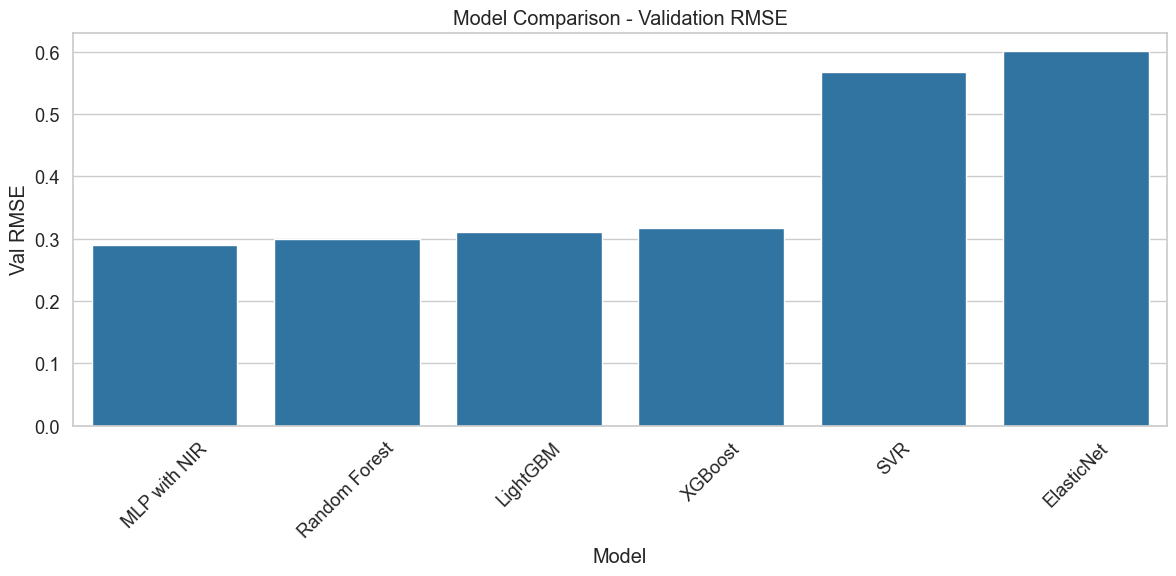

In [11]:
# Model comparison
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train RMSE': [results[model]['train_rmse'] for model in results],
    'Val RMSE': [results[model]['val_rmse'] for model in results],
    'Train R²': [results[model]['train_r2'] for model in results],
    'Val R²': [results[model]['val_r2'] for model in results],
    'Train MAE': [results[model]['train_mae'] for model in results],
    'Val MAE': [results[model]['val_mae'] for model in results],
    'Training Time (s)': [results[model]['training_time'] for model in results],
    'Preprocessing': [results[model].get('preprocessing', 'N/A') for model in results]
})

print("\nModel Comparison:")
display(comparison_df.sort_values('Val RMSE'))

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Val RMSE', data=comparison_df.sort_values('Val RMSE'))
plt.title('Model Comparison - Validation RMSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# Save the best model
best_model_name = comparison_df.sort_values('Val RMSE').iloc[0]['Model']
if best_model_name == "MLP with NIR":
    best_model = best_mlp
else:
    best_model = models[best_model_name]

joblib.dump(best_model, f'nir_tomato_best_{best_model_name.lower().replace(" ", "_")}_model.joblib')
print(f"\nBest model ({best_model_name}) saved successfully!")

model_details = {
    'best_model_name': best_model_name,
    'model_results': results,
    'comparison_df': comparison_df,
}

joblib.dump(model_details, 'nir_tomato_model_details_with_nir_preprocessing.joblib')


Best model (MLP with NIR) saved successfully!


['nir_tomato_model_details_with_nir_preprocessing.joblib']

## 4. Evaluate on Test Set

In [13]:
y_test_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\nFinal Evaluation on Test Set:")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")


Final Evaluation on Test Set:
Test RMSE: 0.3200
Test R²: 0.6914
Test MAE: 0.2446
